In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/avg_dataset.csv'

data = pd.read_csv(file_path)

print(data)

               BVP       EDA          HR       TEMP     ACC_X     ACC_Y  \
0       845.104211  1.187808   74.608115  33.150470  0.469915  0.330743   
1       577.074231  0.184051  148.274501  37.360972 -0.049948  0.606733   
2      1348.771487  1.237474   96.155261  41.244894  0.351758  1.408030   
3       763.476530  0.425882   66.410493  37.810594  1.366609  0.560810   
4      1040.516412  1.561207  124.096788  36.944136  0.794486  1.629755   
...            ...       ...         ...        ...       ...       ...   
49995  1522.592178  0.325510  146.221014  40.262384  0.590381  0.492371   
49996   795.489960  1.110974  131.148453  34.346785  0.966533  1.723344   
49997  1350.316776  0.766641   57.349991  37.846922  0.613623  1.872556   
49998   695.738814  1.133375   86.106525  35.057996  0.457295  0.338952   
49999   822.951598  0.108013  140.457207  38.308989  0.017396  1.111497   

          ACC_Z  Label  
0     -0.115691    1.0  
1      0.948952    1.0  
2      0.654429    0.0  

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout

DATA *CLEANING*

In [4]:
#missing values
missing_counts = data.isnull().sum()  # Count of missing values per column
missing_percentage = data.isnull().mean() * 100  # Percentage of missing values per column
print("Missing Values Count:\n", missing_counts)
print("\nMissing Values Percentage:\n", missing_percentage)

Missing Values Count:
 BVP      0
EDA      0
HR       0
TEMP     0
ACC_X    0
ACC_Y    0
ACC_Z    0
Label    0
dtype: int64

Missing Values Percentage:
 BVP      0.0
EDA      0.0
HR       0.0
TEMP     0.0
ACC_X    0.0
ACC_Y    0.0
ACC_Z    0.0
Label    0.0
dtype: float64


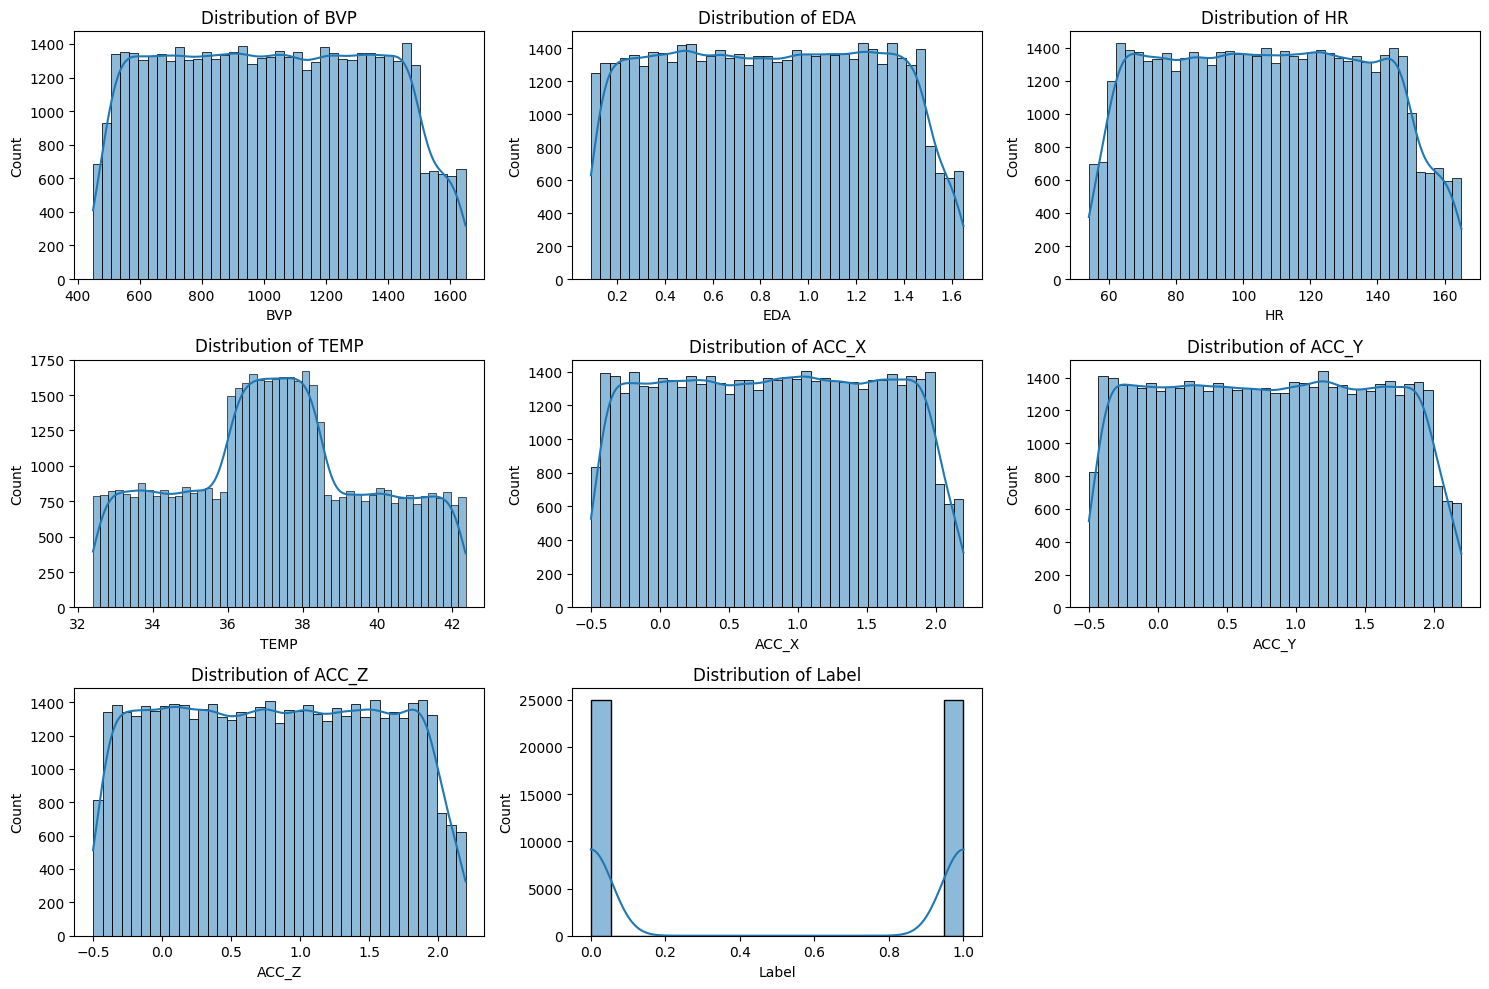

In [5]:
#scaling
#checking distribution to see if scaling is needed
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting grid
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [6]:
# Make a copy of the data to apply transformations
data_scaled = data.copy()

In [7]:
min_max_scaler = MinMaxScaler()

# Apply Min-Max scaling to BVP, TEMP, ACC_X, ACC_Y, ACC_Z
data_scaled[['BVP', 'TEMP', 'ACC_X', 'ACC_Y', 'ACC_Z']] = min_max_scaler.fit_transform(data[['BVP', 'TEMP', 'ACC_X', 'ACC_Y', 'ACC_Z']])

In [8]:
data_scaled['EDA'] = np.log1p(data['EDA'])
# Standardize the log-transformed EDA data
eda_scaler = StandardScaler()
data_scaled['EDA'] = eda_scaler.fit_transform(data_scaled[['EDA']])

In [9]:
#Z-score Standardization for HR
hr_scaler = StandardScaler()
data_scaled['HR'] = hr_scaler.fit_transform(data[['HR']])

In [10]:
print(data_scaled.head())

        BVP       EDA        HR      TEMP     ACC_X     ACC_Y     ACC_Z  Label
0  0.329258  0.840210 -1.103661  0.075337  0.359238  0.307669  0.142337    1.0
1  0.105895 -1.686939  1.394804  0.498549  0.166687  0.409890  0.536699    1.0
2  0.748989  0.932608 -0.372869  0.888935  0.315474  0.706675  0.427603    0.0
3  0.261234 -0.921958 -1.381691  0.543742  0.691362  0.392881  0.393961    0.0
4  0.492105  1.488828  0.574794  0.456651  0.479455  0.788797  0.438583    0.0


In [11]:
#duplicate values
data_scaled = data_scaled.drop_duplicates()
print("Data shape after removing duplicates:", data_scaled.shape)

Data shape after removing duplicates: (50000, 8)


EDA

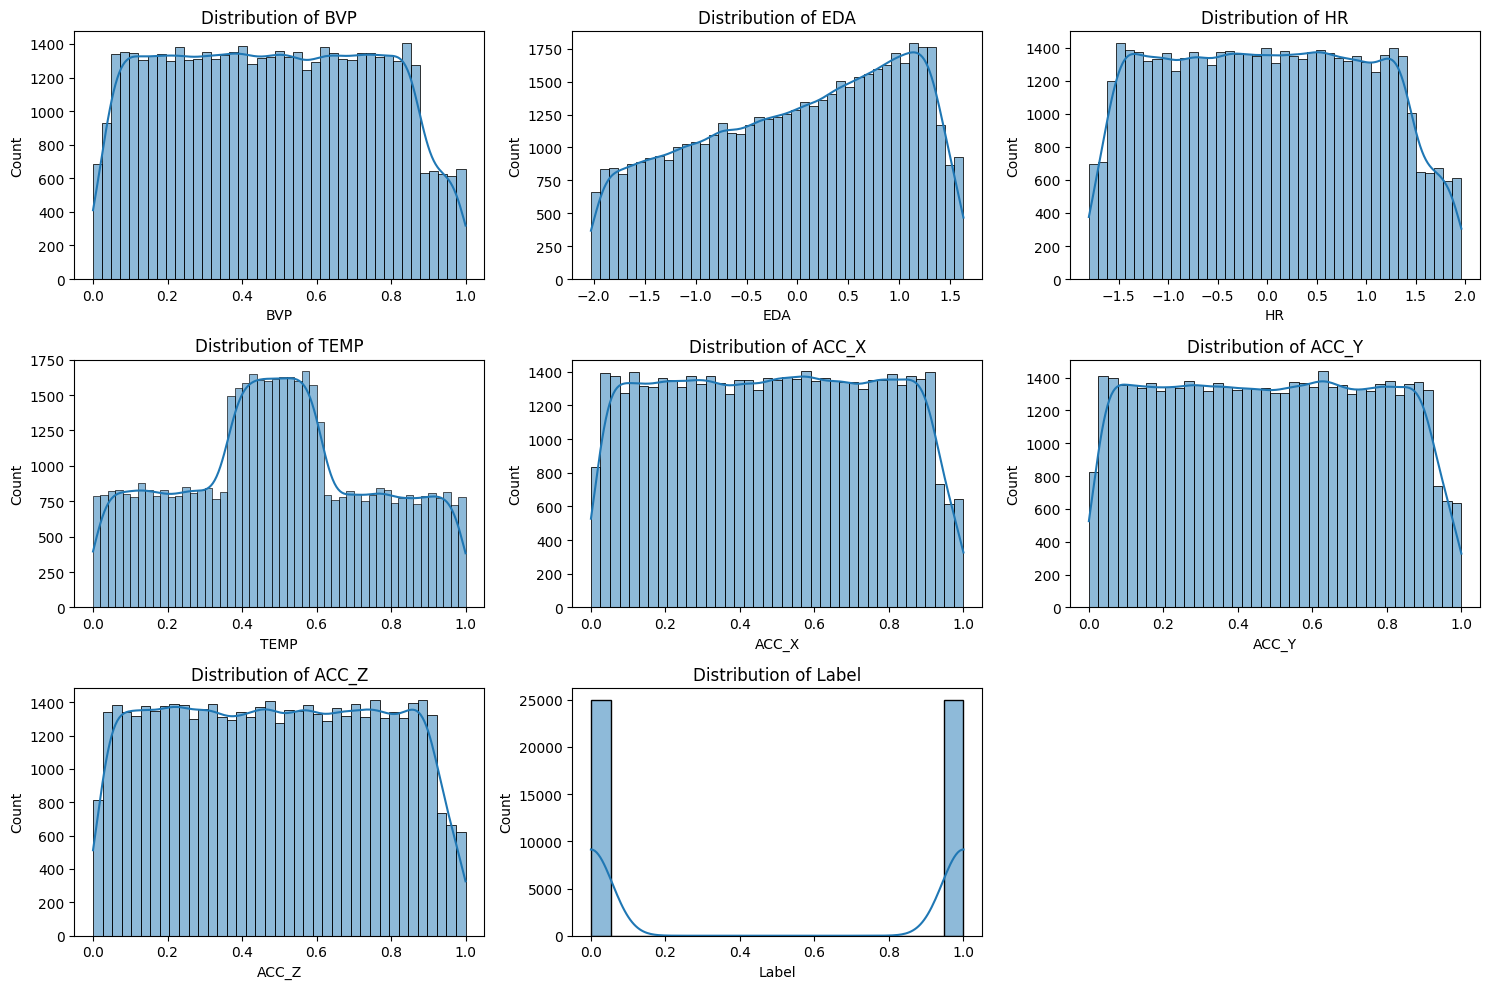

In [12]:
#overall distribution analysis
numeric_cols = data_scaled.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))

# Plot histograms and KDE plots for each numeric feature
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_scaled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

<ipython-input-13-9156509b7ea8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=data_scaled, palette='viridis')


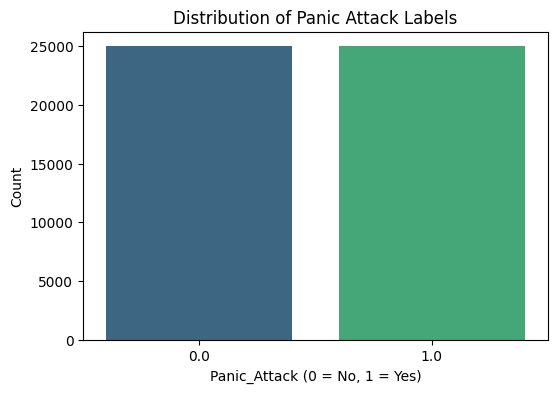

In [13]:
#to check imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=data_scaled, palette='viridis')
plt.title("Distribution of Panic Attack Labels")
plt.xlabel("Panic_Attack (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [14]:
#feature relationship with panic_attack column
features = ['BVP', 'EDA', 'HR', 'TEMP', 'ACC_X', 'ACC_Y', 'ACC_Z']

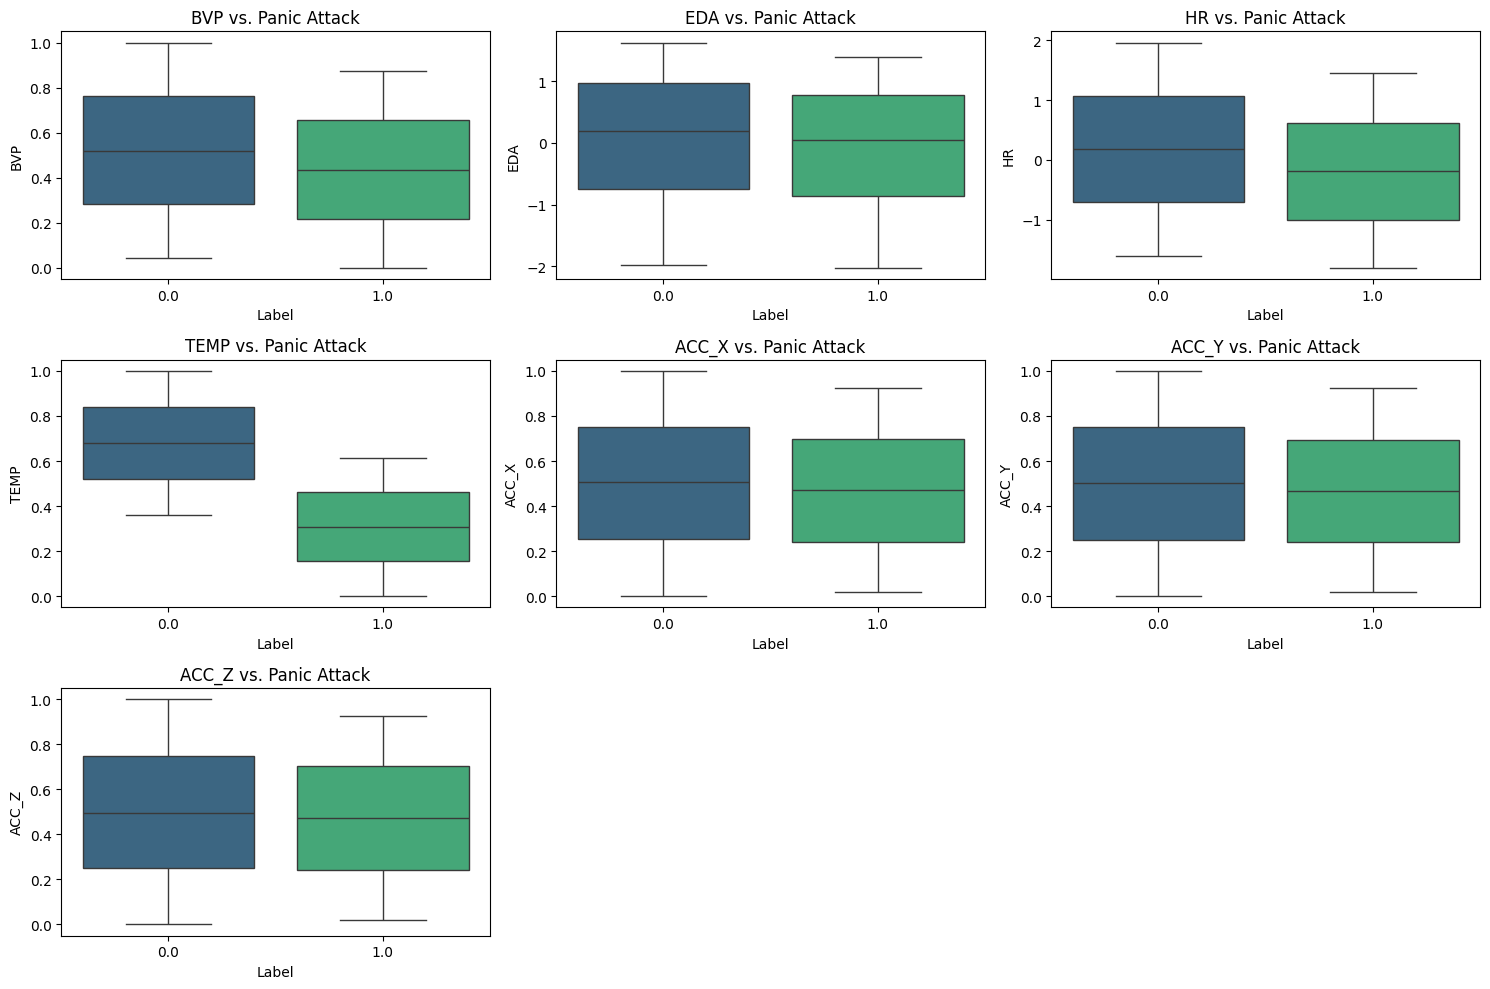

In [15]:
#box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Label', y=col, data=data_scaled, hue='Label', palette='viridis', dodge=False)
    plt.title(f'{col} vs. Panic Attack')
    plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

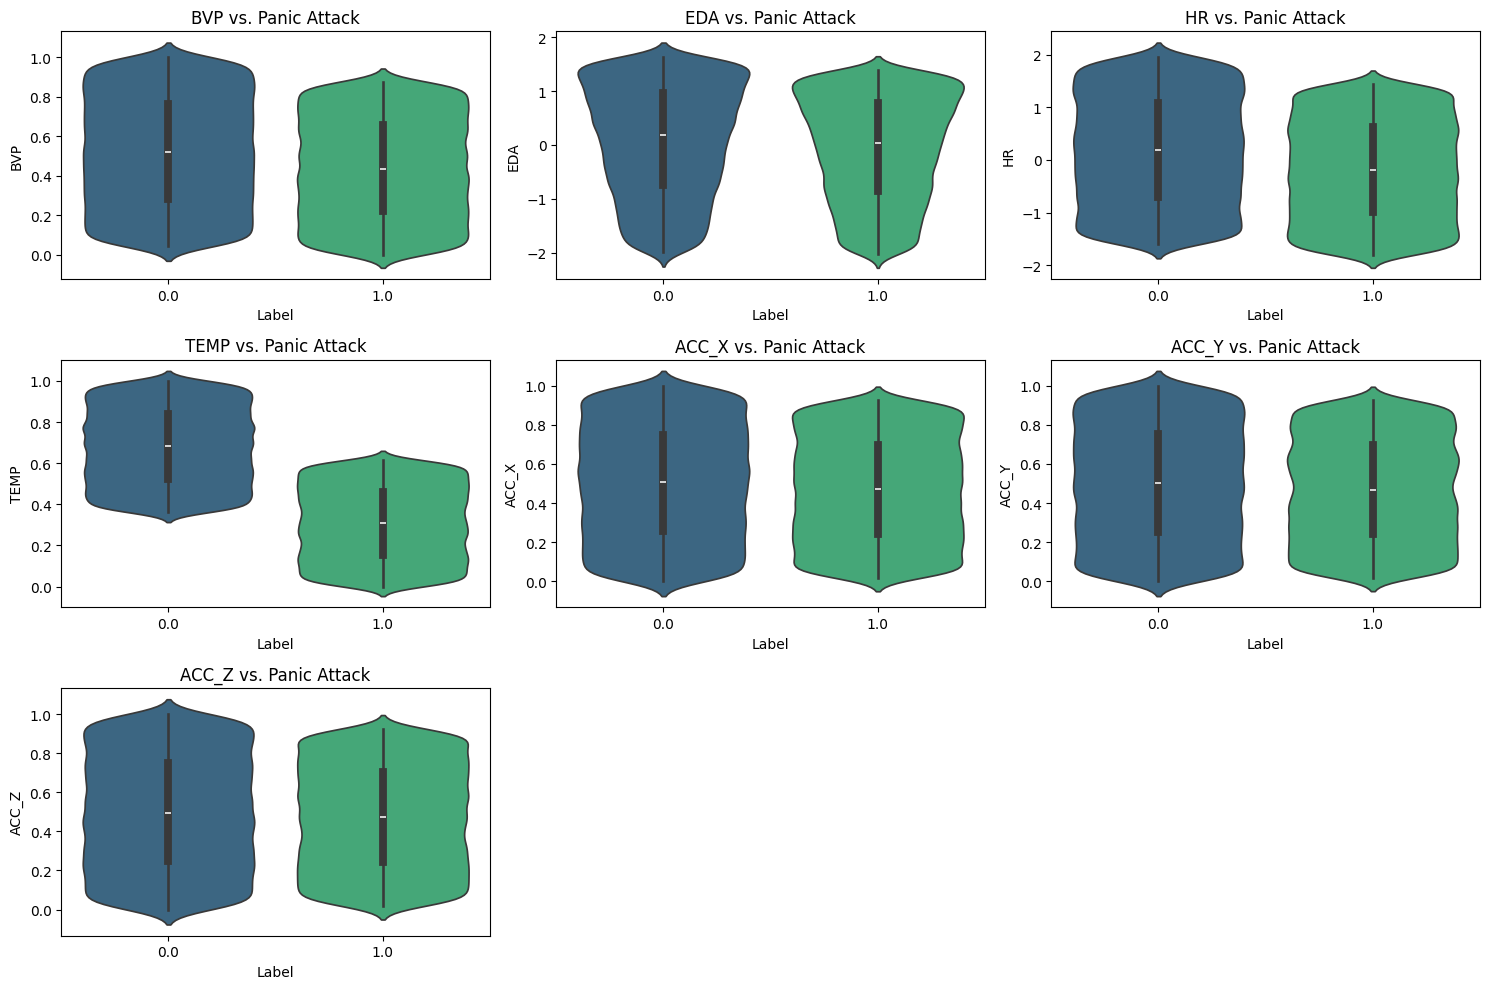

In [16]:
#violin plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='Label', y=col, data=data_scaled, hue='Label', palette='viridis', dodge=False)
    plt.title(f'{col} vs. Panic Attack')
    plt.legend([],[], frameon=False)  # Remove extra legend for clarity
plt.tight_layout()
plt.show()

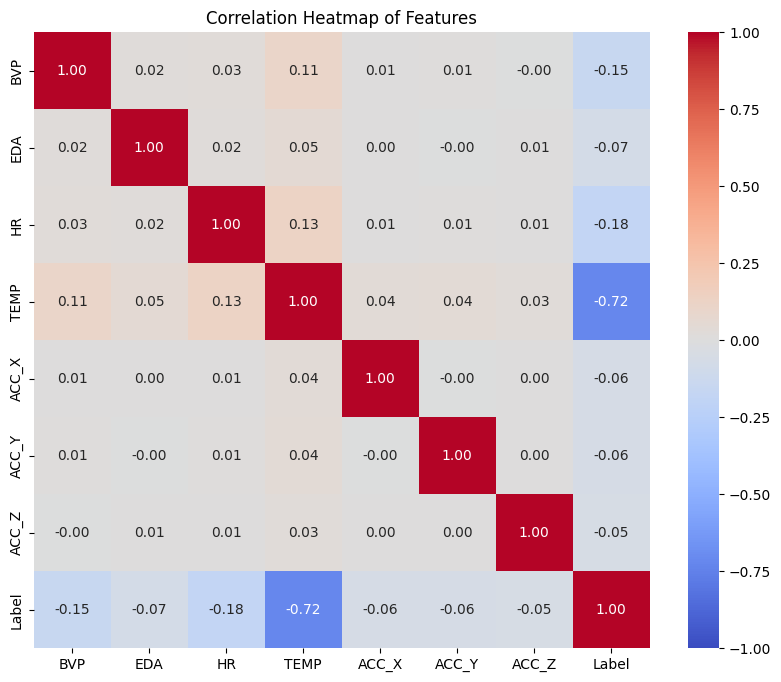

In [17]:
#to check correlation
correlation_matrix = data_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

BVP and TEMP:
A weak positive correlation (0.11) suggests that as body temperature increases, there might be a slight increase in blood volume pulse. However, this relationship is not strong enough to directly infer physiological arousal due to panic attacks.

BVP and ACC_X:
A very weak positive correlation (0.01) indicates almost no relationship between BVP and movement along the X-axis. This suggests that motion along this axis may not significantly affect BVP readings in this dataset.

ACC_Y and ACC_X:
No significant correlation (0.00) indicates independent movement detection along these axes, which could imply that motion along one axis does not necessarily predict motion along the other during panic episodes.

EDA (Electrodermal Activity):
EDA shows minimal correlation with other features (e.g., Label: -0.07, HR: 0.02). While it is weakly related to the target label, it could provide complementary information when combined with other features.

Accelerometer Axes (ACC_X, ACC_Y, ACC_Z):

ACC_X and Label: Weak negative correlation (-0.06) indicates limited relevance of horizontal motion for detecting panic states.
ACC_Y and Label: Similarly weak negative correlation (-0.06) suggests minimal impact of vertical motion along the Y-axis.
ACC_Z and Label: Weakest negative correlation (-0.05), implying that motion along the Z-axis has negligible relevance.





In [18]:
#line plots to see changes/spikes over time
short_window = 5
long_window = 30

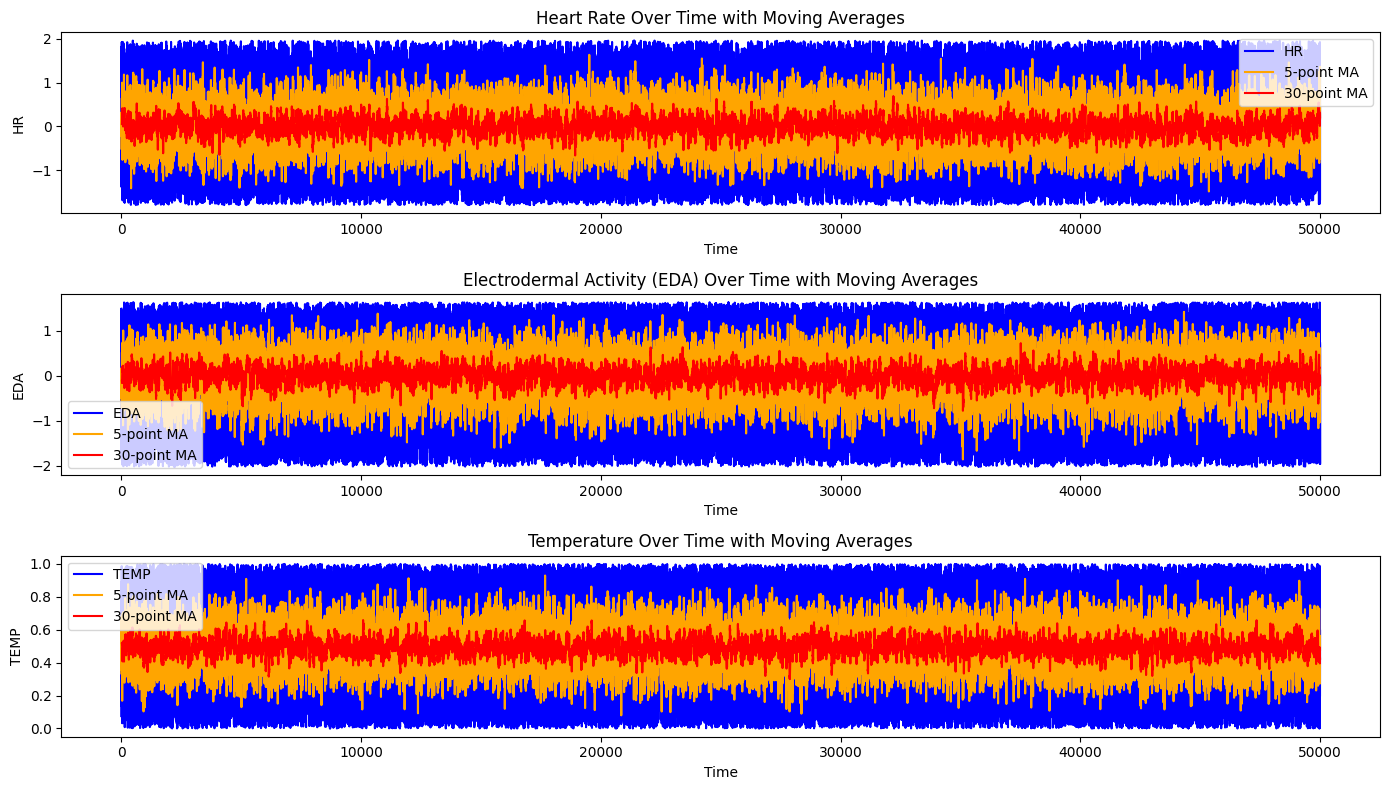

In [19]:
plt.figure(figsize=(14, 8))

#for hr
plt.subplot(3, 1, 1)
plt.plot(data_scaled['HR'], label='HR', color='blue')
plt.plot(data_scaled['HR'].rolling(window=short_window).mean(), label=f'{short_window}-point MA', color='orange')
plt.plot(data_scaled['HR'].rolling(window=long_window).mean(), label=f'{long_window}-point MA', color='red')
plt.title('Heart Rate Over Time with Moving Averages')
plt.xlabel('Time')
plt.ylabel('HR')
plt.legend();

#for EDA
plt.subplot(3, 1, 2)
plt.plot(data_scaled['EDA'], label='EDA', color='blue')
plt.plot(data_scaled['EDA'].rolling(window=short_window).mean(), label=f'{short_window}-point MA', color='orange')
plt.plot(data_scaled['EDA'].rolling(window=long_window).mean(), label=f'{long_window}-point MA', color='red')
plt.title('Electrodermal Activity (EDA) Over Time with Moving Averages')
plt.xlabel('Time')
plt.ylabel('EDA')
plt.legend();

#for TEMP
plt.subplot(3, 1, 3)
plt.plot(data_scaled['TEMP'], label='TEMP', color='blue')
plt.plot(data_scaled['TEMP'].rolling(window=short_window).mean(), label=f'{short_window}-point MA', color='orange')
plt.plot(data_scaled['TEMP'].rolling(window=long_window).mean(), label=f'{long_window}-point MA', color='red')
plt.title('Temperature Over Time with Moving Averages')
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.legend();

plt.tight_layout()
plt.show()

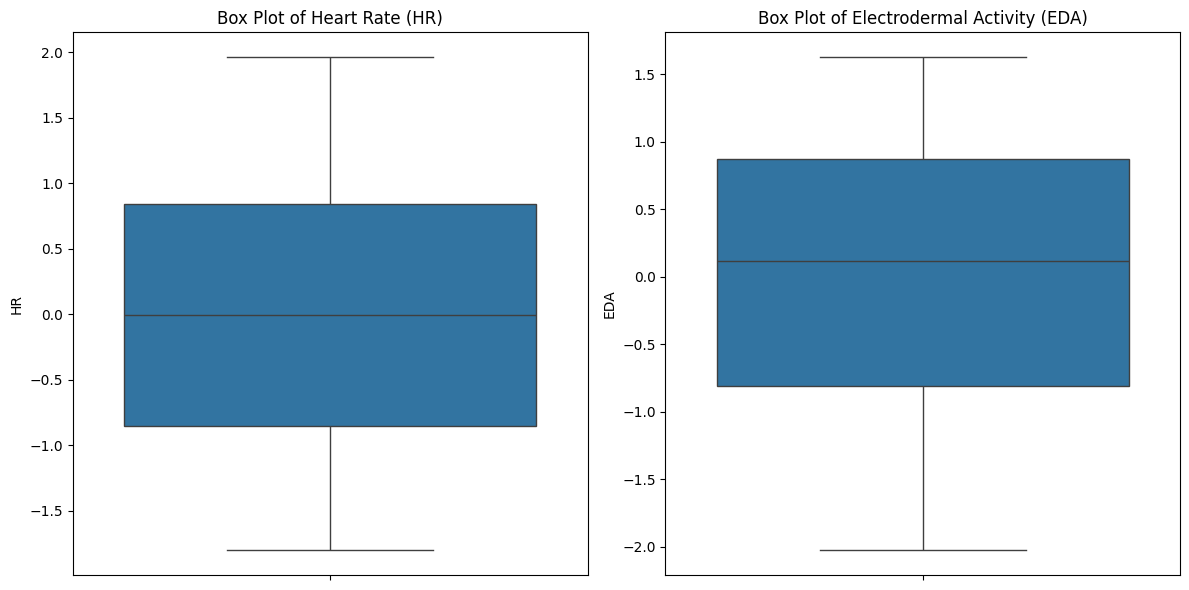

In [20]:
#outliers
#box plots
plt.figure(figsize=(12, 6))

#for HR
plt.subplot(1, 2, 1)
sns.boxplot(y=data_scaled['HR'])
plt.title("Box Plot of Heart Rate (HR)")

#for EDA
plt.subplot(1, 2, 2)
sns.boxplot(y=data_scaled['EDA'])
plt.title("Box Plot of Electrodermal Activity (EDA)")

plt.tight_layout()
plt.show()

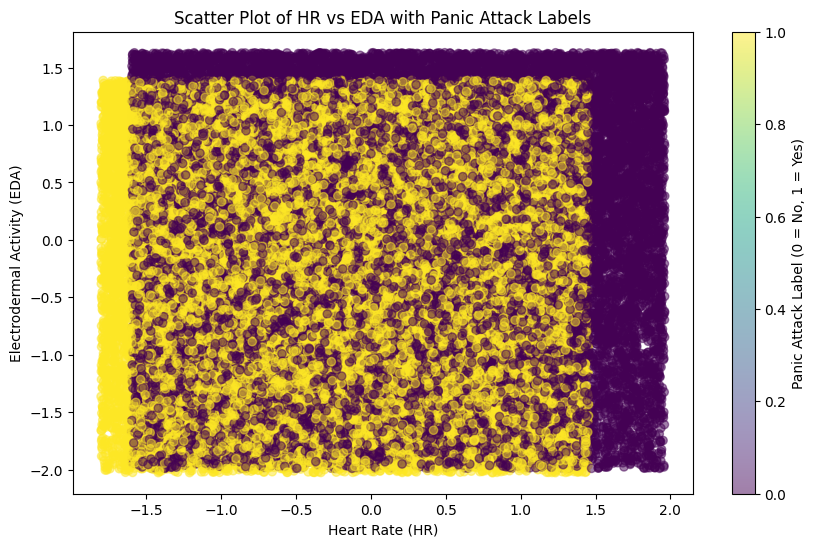

In [21]:
#Scatter plot to identify any extreme values in HR vs EDA
plt.figure(figsize=(10, 6))
plt.scatter(data_scaled['HR'], data_scaled['EDA'], alpha=0.5, c=data_scaled['Label'], cmap='viridis')
plt.colorbar(label='Panic Attack Label (0 = No, 1 = Yes)')
plt.xlabel("Heart Rate (HR)")
plt.ylabel("Electrodermal Activity (EDA)")
plt.title("Scatter Plot of HR vs EDA with Panic Attack Labels")
plt.show()

In [22]:
import joblib
import os

# Create the scalers directory if it doesn't exist
os.makedirs("scalers", exist_ok=True)

# Save the scalers
joblib.dump(min_max_scaler, "scalers/min_max_scaler.pkl")
joblib.dump(eda_scaler, "scalers/eda_scaler.pkl")
joblib.dump(hr_scaler, "scalers/hr_scaler.pkl")

print("Scalers saved successfully to the 'scalers' directory.")


Scalers saved successfully to the 'scalers' directory.


SUPERVISED MODELS


In [23]:
#splitting data
X = data_scaled.drop(columns=['Label'])
y = data_scaled['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [24]:
#Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest - Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.82      0.89      9918
         1.0       0.84      0.98      0.90     10082

    accuracy                           0.90     20000
   macro avg       0.91      0.90      0.90     20000
weighted avg       0.91      0.90      0.90     20000

Random Forest - Confusion Matrix:
 [[8103 1815]
 [ 252 9830]]


In [25]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# Example: Assuming rf_model is trained
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


In [26]:
from google.colab import files

# Download the saved model
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
#xgboost
# Calculate scale_pos_weight for imbalance handling
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train XGBoost
xgb_model = XGBClassifier(scale_pos_weight=class_ratio, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost - Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost - Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      9918
         1.0       0.85      0.95      0.90     10082

    accuracy                           0.89     20000
   macro avg       0.90      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

XGBoost - Confusion Matrix:
 [[8179 1739]
 [ 485 9597]]


In [28]:
#Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      9918
         1.0       0.82      0.82      0.82     10082

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Logistic Regression - Confusion Matrix:
 [[8098 1820]
 [1857 8225]]


In [29]:
#SVM
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM - Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM - Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      9918
         1.0       0.84      0.87      0.85     10082

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

SVM - Confusion Matrix:
 [[8193 1725]
 [1347 8735]]


In [30]:
# MLP
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)
print("Neural Network (MLP) - Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("Neural Network (MLP) - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))

Neural Network (MLP) - Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.83      0.87      9918
         1.0       0.85      0.91      0.88     10082

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.88      0.87      0.87     20000

Neural Network (MLP) - Confusion Matrix:
 [[8250 1668]
 [ 873 9209]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
#cross validation

scorer = make_scorer(f1_score, average='weighted')

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]), random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=500),
    'SVM': SVC(class_weight='balanced', random_state=42),
    'Neural Network (MLP)': MLPClassifier(random_state=42, max_iter=300)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
    print(f"{name} - Average F1 Score (Weighted): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Random Forest - Average F1 Score (Weighted): 0.8979 (+/- 0.0021)
XGBoost - Average F1 Score (Weighted): 0.8925 (+/- 0.0021)
Logistic Regression - Average F1 Score (Weighted): 0.8176 (+/- 0.0033)
SVM - Average F1 Score (Weighted): 0.8482 (+/- 0.0012)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) - Average F1 Score (Weighted): 0.8752 (+/- 0.0060)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


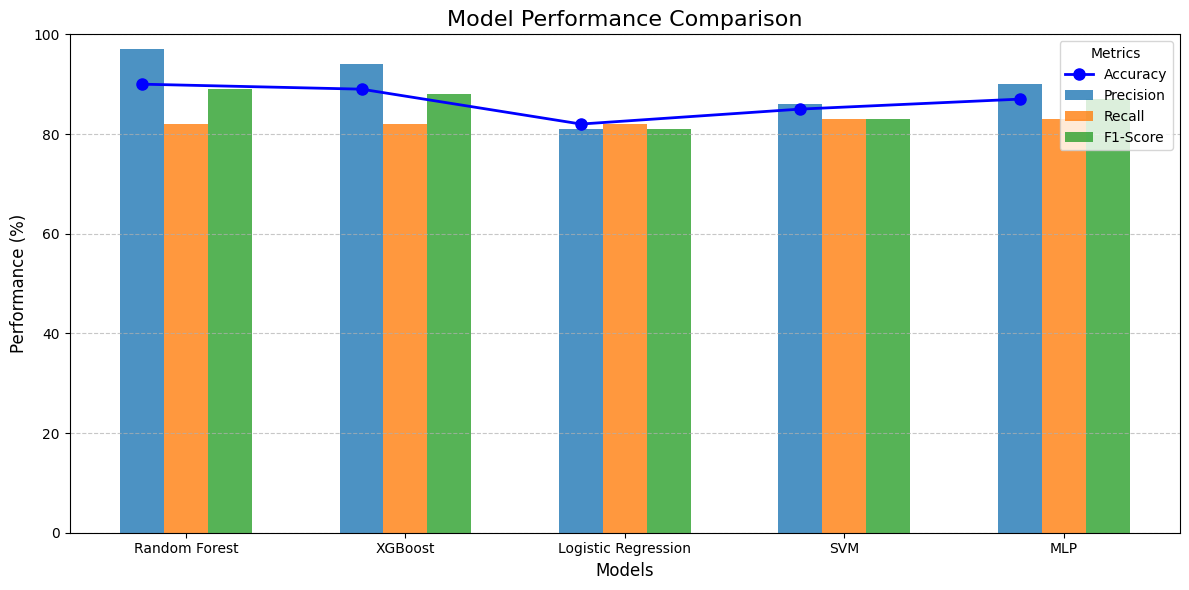

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
models = ["Random Forest", "XGBoost", "Logistic Regression", "SVM", "MLP"]
accuracy = [90, 89, 82, 85, 87]
precision = [97, 94, 81, 86, 90]
recall = [82, 82, 82, 83, 83]
f1_score = [89, 88, 81, 83, 87]

# Metrics data
metrics = [precision, recall, f1_score]
metric_labels = ["Precision", "Recall", "F1-Score"]

# Bar width and positions
x_positions = np.arange(len(models))
bar_width = 0.2

# Plot Accuracy as a line
plt.figure(figsize=(12, 6))
plt.plot(models, accuracy, marker='o', label="Accuracy", color="blue", linewidth=2, markersize=8)

# Plot other metrics as grouped bars
for i, metric in enumerate(metrics):
    plt.bar(x_positions + i * bar_width, metric, width=bar_width, label=metric_labels[i], alpha=0.8)

# Formatting the plot
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Performance (%)", fontsize=12)
plt.xticks(x_positions + bar_width, models, fontsize=10)  # Align x-ticks with models
plt.ylim(0, 100)
plt.legend(title="Metrics", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
